# Predictive Model for IMDB Movie Recommendations

### Import Required Packages

In [187]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor


from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error, make_scorer
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns", 52)
pd.set_option("display.max_rows", 20)

### Read in the Data Frames

In [188]:
imdb_df = pd.read_csv("IMDB Model Data/imdb_data.csv")
reviewed_df= pd.read_csv("IMDB Model Data/reviewed_data.csv")

## Model Building

#### Basic setup for all models

In [189]:
imdb_df

,Const,Title,Director,Famous Director,ReleaseYear,Age,Runtime,LongMovie,genres,Genre1,Genre2,Genre3,numVotes,IMDb Rating,My Rating,DifferenceBetweenRatings,has_rated,Date Rated,lead_cast_1_name,lead_cast_2_name,lead_cast_3_name,SuperFamousMovie,is_christopher_nolan,is_denis_villeneuve,is_quentin_tarantino,is_george_lucas,...,is_robert_zemeckis,is_martin_scorsese,isbiography,iscrime,isdrama,ishistory,ishorror,ismusic,ismystery,isromance,issport,isthriller,iswestern,is_robert_downey_jr.,is_leonardo_dicaprio,is_jim_carrey,is_chris_evans,is_christian_bale,is_chris_pratt,is_jonah_hill,is_rosalie_chiang,is_brie_larson,is_gemma_chan,is_New,is_Old,is_Classic
0,tt0111161,The Shawshank Redemption,Frank Darabont,False,1994,30,142,True,Drama,Drama,NaN,NaN,2964641,9.3,10.0,0.7,True,2022-08-13,Tim Robbins,Morgan Freeman,Bob Gunton,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,tt0068646,The Godfather,Francis Ford Coppola,True,1972,52,175,True,"Crime,Drama",Crime,Drama,NaN,2067431,9.2,NaN,NaN,False,NaN,Marlon Brando,Al Pacino,James Caan,True,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,tt0468569,The Dark Knight,Christopher Nolan,True,2008,16,152,True,"Action,Crime,Drama",Action,Crime,Drama,2946090,9.0,10.0,1.0,True,2022-08-13,Christian Bale,Christian Bale,Heath Ledger,True,True,False,False,False,...,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,tt0167260,The Lord of the Rings: The Return of the King,Peter Jackson,True,2003,21,201,True,"Action,Adventure,Drama",Action,Adventure,Drama,2029646,9.0,NaN,NaN,False,NaN,Elijah Wood,Viggo Mortensen,Ian McKellen,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,tt0108052,Schindler's List,Steven Spielberg,True,1993,31,195,True,"Biography,Drama,History",Biography,Drama,History,1486959,9.0,NaN,NaN,False,NaN,Liam Neeson,Ralph Fiennes,Ben Kingsley,True,False,False,False,False,...,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,tt10886166,365 Days,Multiple Directors,True,2020,4,114,False,"Drama,Romance",Drama,Romance,NaN,101303,3.3,NaN,NaN,False,NaN,Anna-Maria Sieklucka,Michele Morrone,Bronislaw Wroclawski,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2499,tt1073498,Meet the Spartans,Multiple Directors,True,2008,16,87,False,"Comedy,Fantasy",Comedy,Fantasy,NaN,112468,2.8,NaN,NaN,False,NaN,Sean Maguire,Kevin Sorbo,Carmen Electra,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2500,tt12915716,Adipurush,Om Raut,False,2023,1,179,True,"Action,Adventure,Drama",Action,Adventure,Drama,134604,2.7,NaN,NaN,False,NaN,Prabhas,Kriti Sanon,Saif Ali Khan,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2501,tt0799949,Epic Movie,Multiple Directors,True,2007,17,86,False,"Adventure,Comedy,Fantasy",Adventure,Comedy,Fantasy,110452,2.4,NaN,NaN,False,NaN,Kal Penn,Jennifer Coolidge,Fr

In [190]:
target = "My Rating"
badCols = ["Const", "Director", "ReleaseYear", "genres", "Genre1", "Genre2", "Genre3", "numVotes", "has_rated", "Date Rated", "lead_cast_1_name", "lead_cast_2_name", "lead_cast_3_name", "My Rating", "DifferenceBetweenRatings", "Age"]
X = reviewed_df.drop(columns = badCols)
y = reviewed_df[target]

In [191]:
X.index = X.Title
X.drop(columns = "Title", inplace = True)

In [192]:
# Convert dummy columns to numerical columns
X = X*1

## Create the first Model : LassoCV

In [193]:
#Create a Standard Scaler instance
scaler = StandardScaler()

#Fit the scaler to the training data and transform it
X_scaled = scaler.fit_transform(X)

alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

# Create a LassoCV Model
movie_lasso_cv = LassoCV(cv=5, alphas=alphas)

# Fit the model
movie_lasso_cv.fit(X_scaled, y)

# Print the best alpha value
print(f"Best alpha value: {movie_lasso_cv.alpha_}")

Best alpha value: 0.01


/home/cb072/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13202402922500767, tolerance: 0.020818705035971222
  model = cd_fast.enet_coordinate_descent_gram(
/home/cb072/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13204134962840897, tolerance: 0.020818705035971222
  model = cd_fast.enet_coordinate_descent_gram(
/home/cb072/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.849282117455715, tolerance: 0.020818705035971222
  model = cd_fast.enet_coordinate_descent_gram(
/home/cb072/.local/lib/python3.11/site-packages/sklearn/linear_mo

In [194]:
# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions = movie_lasso_cv.predict(X_scaled)
predictions = np.round(np.clip(predictions, 0, 10))

#'LassoCV Prediction' now contains the transformed predictions
reviewed_df["LassoCV Prediction"] = predictions
reviewed_df['LassoCV Prediction Difference'] = reviewed_df['My Rating'] - reviewed_df['LassoCV Prediction']

## Fit the Lasso Model to the larger data frame

In [195]:
# Create a DataFrame with the IMDb data that can be inputted into the model
X_imdb = imdb_df.drop(["Const", "Director", "ReleaseYear", "genres", "Genre1", "Genre2", "Genre3", "numVotes", "has_rated", "Date Rated", "lead_cast_1_name", "lead_cast_2_name", "lead_cast_3_name", "My Rating", "DifferenceBetweenRatings", "Age"], axis=1)

# Convert dummy columns to numerical
X_imdb = X_imdb*1

X_imdb.index = X_imdb.Title
X_imdb.drop(columns = "Title", inplace = True)

# Scale the data
X_imdb_scaled = scaler.transform(X_imdb)

# Predict ratings
predictions = movie_lasso_cv.predict(X_imdb_scaled)

# Clip predictions to the 0-10 range but do not round them because it will make it easier to find the highest predicted ratings
# Add a second value to get the overflow above 10 to use as the second sorting value
overflow = np.where(predictions > 10, predictions - 10, 0)
predictions = np.clip(predictions, 0, 10)
predictions = np.round(predictions, 2)

# 'predictions' now contains the transformed predictions
imdb_df["LassoCV Prediction"] = predictions
imdb_df["LassoCV Overflow"] = overflow

### Explore Coefficients and Features of the built model

In [196]:
# Find coefficients of the model
coefficients = movie_lasso_cv.coef_
features = X.columns  # X being the DataFrame of input features
dropped_features = features[coefficients == 0]

# Create a DataFrame to view the coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df[coef_df['Coefficient'] != 0]  # Filter out zero coefficients

print(coef_df.sort_values(by='Coefficient', ascending=False))
formula = ""
for index, row in coef_df.iterrows():
    formula += f"{row['Coefficient']}*{row['Feature']} + "
print("Regression Formula :", formula)
print(dropped_features)


                 Feature  Coefficient
3            IMDb Rating     0.888194
25             iswestern     0.168109
16               iscrime     0.161978
28         is_jim_carrey     0.157420
24            isthriller     0.150784
..                   ...          ...
35         is_gemma_chan    -0.119216
34        is_brie_larson    -0.120081
0        Famous Director    -0.148653
33     is_rosalie_chiang    -0.179917
7   is_quentin_tarantino    -0.196761

[33 rows x 2 columns]
Regression Formula : -0.1486532571038453*Famous Director + 0.02207817539782216*Runtime + 0.8881941200767585*IMDb Rating + -0.11884187818744352*SuperFamousMovie + 0.03971171376161207*is_christopher_nolan + 0.09116157740858342*is_denis_villeneuve + -0.19676072246451817*is_quentin_tarantino + 0.054999324672459576*is_george_lucas + 0.09009548227874135*is_sam_raimi + 0.015940388778690598*is_steven_spielberg + 0.04337770677915392*is_ridley_scott + -0.055138661824574046*is_tim_burton + 0.0109135868050184*is_robert_zemeckis

## Create the second Model : Random Forest Regressor

In [197]:
# These were the best hyperparameters found by the RandomizedSearchCV
param_grid = {
  'n_estimators': [15,65,75],
  'min_samples_split': [10,12,15],
  'min_samples_leaf': [1, 2, 3,],
  'min_impurity_decrease': [0, 0.001, 0.01],
  'max_depth': [10,13,15,20,25]
}

In [198]:
randomforestsearch = GridSearchCV(
    RandomForestRegressor(random_state=0),
    param_grid=param_grid,
    cv=5,
    scoring = 'neg_mean_absolute_error',
    verbose=2,
    n_jobs=1  # Disable parallel processing to avoid serialization issues
)

randomforestsearch = randomforestsearch.fit(X, y)
train_mae = mean_absolute_error(y, randomforestsearch.predict(X))
print(f"Train MAE: {train_mae}")
print("Best parameters found: ", randomforestsearch.best_params_)
print("Lowest MAE found: ", randomforestsearch.best_score_)

rf_model = randomforestsearch.best_estimator_

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=15; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=15; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=15; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=15; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=15; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=65; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=10, n_estimators=65; total time=   0.0s
[CV] END max_depth=10, min_impurity_decrease=0, min_sa

/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [199]:
# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions = rf_model.predict(X)
predictions = np.round(np.clip(predictions, 0, 10))

#'LassoCV Prediction' now contains the transformed predictions
reviewed_df["Random Forest Regressor Prediction"] = predictions
reviewed_df['Random Forest Regressor Prediction Difference'] = reviewed_df['My Rating'] - reviewed_df['Random Forest Regressor Prediction']

## Fit the Random Forest Regressor to the larger Data Frame

In [200]:
# Predict ratings
predictions = randomforestsearch.predict(X_imdb)
# Clip predictions to the 0-10 range but do not round them because it will make it easier to find the highest predicted ratings
# Add a second value to get the overflow above 10 to use as the second sorting value
overflow = np.where(predictions > 10, predictions - 10, 0)
predictions = np.clip(predictions, 0, 10)
predictions = np.round(predictions, 2)

# 'predictions' now contains the transformed predictions
imdb_df["Random Forest Regressor Prediction"] = predictions
imdb_df["Random Forest Regressor Prediction Overflow"] = overflow

In [201]:
# Most important features 
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
important_features = features[indices]
print(important_features)

Index(['IMDb Rating', 'Runtime', 'isdrama', 'Famous Director',
       'SuperFamousMovie', 'is_Classic', 'isthriller', 'is_christopher_nolan',
       'iscrime', 'is_New', 'is_Old', 'ismystery', 'is_christian_bale',
       'LongMovie', 'is_quentin_tarantino', 'isbiography', 'is_jim_carrey',
       'is_leonardo_dicaprio', 'is_robert_downey_jr.', 'is_sam_raimi',
       'is_george_lucas', 'is_brie_larson', 'is_denis_villeneuve',
       'is_ridley_scott', 'is_gemma_chan', 'is_steven_spielberg',
       'is_jonah_hill', 'is_tim_burton', 'is_robert_zemeckis',
       'is_martin_scorsese', 'is_chris_pratt', 'is_rosalie_chiang',
       'ishistory', 'ismusic', 'isromance', 'issport', 'iswestern',
       'is_chris_evans', 'ishorror'],
      dtype='object')


## Create a third Model : Neural Network

In [202]:
# Import libraries
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the function to create the Keras model
def create_keras_model(optimizer='adam', learning_rate=0.001):
    model = Sequential()
    # Input and first hidden layer
    model.add(Dense(24, input_dim=39, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    # Second hidden layer
    model.add(Dense(12, activation='relu', kernel_regularizer=l2(0.01)))
    # Output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Wrap the Keras model using KerasRegressor
regressor = KerasRegressor(
    model=create_keras_model,
    verbose=0
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'batch_size': [5, 10],            # Batch sizes to test
    'epochs': [150, 200],             # Epoch counts to test
    'model__optimizer': ['rmsprop'],  # Optimizers to test
    'model__learning_rate': [0.001, 0.0005]    # Learning rates to test
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as evaluation metric
    n_jobs=1,  # Disable parallel processing to avoid serialization issues
    verbose=2
)

# Fit the grid search model using the entire dataset
grid_search.fit(X_scaled, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output results
print(f"Best Parameters: {best_params}")

/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END batch_size=5, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   5.0s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.3s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.2s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.3s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.1s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.0s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.1s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   3.5s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   5.3s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   5.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   5.8s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   5.5s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   5.1s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   5.2s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   5.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   5.2s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=5, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.5s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   3.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   3.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   3.5s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   3.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   3.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.0s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   3.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   3.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   3.8s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=150, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   3.1s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.4s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.3s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   4.5s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.001, model__optimizer=rmsprop; total time=   3.8s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.2s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.6s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.7s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   4.5s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=10, epochs=200, model__learning_rate=0.0005, model__optimizer=rmsprop; total time=   3.8s


/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'batch_size': 5, 'epochs': 200, 'model__learning_rate': 0.001, 'model__optimizer': 'rmsprop'}


In [203]:
from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasRegressor

# Wrap the Keras model using KerasRegressor
wrapped_best_model = KerasRegressor(model=create_keras_model, optimizer=best_params['model__optimizer'], learning_rate=best_params['model__learning_rate'], epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Fit the wrapped model
wrapped_best_model.fit(X_scaled, y)

# Calculate the permutation feature importance
result = permutation_importance(wrapped_best_model, X_scaled, y, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

# Get the importance scores
importance_scores = result.importances_mean

# Create a DataFrame to view the feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

/usr/remote/apps/anaconda/2024.02-1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


               Feature  Importance
3          IMDb Rating    0.661349
1              Runtime    0.092701
0      Famous Director    0.085820
16             iscrime    0.061538
38          is_Classic    0.043145
..                 ...         ...
12       is_tim_burton    0.008800
18           ishistory    0.005354
11     is_ridley_scott    0.004489
22           isromance    0.004374
13  is_robert_zemeckis    0.002273

[39 rows x 2 columns]


In [204]:
y_pred = best_model.predict(X_scaled)

# Calculate and print performance metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

predictions = best_model.predict(X_imdb_scaled)
# Add a second value to get the overflow above 10 to use as the second sorting value
overflow = np.where(predictions > 10, predictions - 10, 0)
predictions = np.round(np.clip(predictions, 0, 10),2)

Best Parameters: {'batch_size': 5, 'epochs': 200, 'model__learning_rate': 0.001, 'model__optimizer': 'rmsprop'}
Mean Squared Error: 0.3634304496170538
Mean Absolute Error: 0.4525867275808049


In [205]:
# Add a second value to get the overflow above 10 to use as the second sorting value
overflow = np.where(y_pred > 10, y_pred - 10, 0)
predictions = np.round(np.clip(y_pred, 0, 10),2)

reviewed_df["Neural Network Prediction"] = predictions
reviewed_df['Neural Network Prediction Overflow'] = overflow
reviewed_df['Neural Network Prediction Difference'] = reviewed_df['My Rating'] - reviewed_df['Neural Network Prediction']

In [206]:
reviewed_df.sort_values(by='Neural Network Prediction', ascending=False)

,Const,Title,Director,Famous Director,ReleaseYear,Age,Runtime,LongMovie,genres,Genre1,Genre2,Genre3,numVotes,IMDb Rating,My Rating,DifferenceBetweenRatings,has_rated,Date Rated,lead_cast_1_name,lead_cast_2_name,lead_cast_3_name,SuperFamousMovie,is_christopher_nolan,is_denis_villeneuve,is_quentin_tarantino,is_george_lucas,...,ismusic,ismystery,isromance,issport,isthriller,iswestern,is_robert_downey_jr.,is_leonardo_dicaprio,is_jim_carrey,is_chris_evans,is_christian_bale,is_chris_pratt,is_jonah_hill,is_rosalie_chiang,is_brie_larson,is_gemma_chan,is_New,is_Old,is_Classic,LassoCV Prediction,LassoCV Prediction Difference,Random Forest Regressor Prediction,Random Forest Regressor Prediction Difference,Neural Network Prediction,Neural Network Prediction Overflow,Neural Network Prediction Difference
87,tt0144084,American Psycho,Mary Harron,False,2000,24,102,False,"Crime,Drama,Horror",Crime,Drama,Horror,750488,7.6,10.0,2.4,True,2022-08-15,Christian Bale,Justin Theroux,Josh Lucas,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,9.0,1.0,9.0,1.0,10.00,0.021380,0.00
11,tt1853728,Django Unchained,Quentin Tarantino,True,2012,12,165,True,"Comedy,Drama,Western",Comedy,Drama,Western,1741750,8.5,10.0,1.5,True,2022-08-13,Jamie Foxx,Christoph Waltz,Leonardo DiCaprio,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,10.0,0.0,10.0,0.0,10.00,0.447191,0.00
1,tt0468569,The Dark Knight,Christopher Nolan,True,2008,16,152,True,"Action,Crime,Drama",Action,Crime,Drama,2946090,9.0,10.0,1.0,True,2022-08-13,Christian Bale,Christian Bale,Heath Ledger,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,10.0,0.0,10.0,0.0,10.00,0.735352,0.00
34,tt1130884,Shutter Island,Martin Scorsese,True,2010,14,138,True,"Drama,Mystery,Thriller",Drama,Mystery,Thriller,1504277,8.2,10.0,1.8,True,2022-08-14,Leonardo DiCaprio,Emily Mortimer,Mark Ruffalo,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,10.0,0.0,9.0,1.0,10.00,0.462908,0.00
31,tt15398776,Oppenheimer,Christopher Nolan,True,2023,1,180,True,"Biography,Drama,History",Biography,Drama,History,815630,8.3,10.0,1.7,True,2023-07-23,Cillian Murphy,Emily Blunt,Matt Damon,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,10.0,0.0,10.0,0.0,10.00,0.104773,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,tt0367594,Charlie and the Chocolate Factory,Tim Burton,True,2005,19,115,False,"Adventure,Comedy,Family",Adventure,Comedy,Family,540946,6.7,6.0,-0.7,True,2024-03-19,Johnny Depp,Freddie Highmore,David Kelly,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,6.0,0.0,7.0,-1.0,6.01,0.000000,-0.01
165,tt7991608,Red Notice,Rawson Marshall Thurber,True,2021,3,118,False,"Action,Comedy,Thriller",Action,Comedy,Thriller,329365,6.3,5.0,-1.3,True,2024-11-18,Dwayne Johnson,Ryan Reynolds,Gal Gadot,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,7.0,-2.0,6.0,-1.0,6.00,0.000000,-1.00
133,tt8097030,Turning Red,Domee Shi,False,2022,2,100,False,"Adventure,Animation,Comedy",Adventure,Animation,Comedy,159768,7.0,5.0,-2.0,True,2024-03-20,Rosalie Chiang,Rosalie Chiang,Sandra Oh,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,5.0,0.0,7.0,-2.

## Fit To Larger Data Frame

In [207]:
predictions = best_model.predict(X_imdb_scaled)
# Add a second value to get the overflow above 10 to use as the second sorting value
overflow = np.where(predictions > 10, predictions - 10, 0)
predictions = np.round(np.clip(predictions, 0, 10),2)

imdb_df["Neural Network Prediction"] = predictions
imdb_df["Neural Network Prediction Overflow"] = overflow

In [208]:
imdb_df.sort_values(by=['Neural Network Prediction','Neural Network Prediction Overflow'], ascending=False)

,Const,Title,Director,Famous Director,ReleaseYear,Age,Runtime,LongMovie,genres,Genre1,Genre2,Genre3,numVotes,IMDb Rating,My Rating,DifferenceBetweenRatings,has_rated,Date Rated,lead_cast_1_name,lead_cast_2_name,lead_cast_3_name,SuperFamousMovie,is_christopher_nolan,is_denis_villeneuve,is_quentin_tarantino,is_george_lucas,...,ishorror,ismusic,ismystery,isromance,issport,isthriller,iswestern,is_robert_downey_jr.,is_leonardo_dicaprio,is_jim_carrey,is_chris_evans,is_christian_bale,is_chris_pratt,is_jonah_hill,is_rosalie_chiang,is_brie_larson,is_gemma_chan,is_New,is_Old,is_Classic,LassoCV Prediction,LassoCV Overflow,Random Forest Regressor Prediction,Random Forest Regressor Prediction Overflow,Neural Network Prediction,Neural Network Prediction Overflow
13,tt0060196,"The Good, the Bad and the Ugly",Sergio Leone,True,1966,58,178,True,"Adventure,Drama,Western",Adventure,Drama,Western,831223,8.8,NaN,NaN,False,NaN,Clint Eastwood,Eli Wallach,Lee Van Cleef,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,10.00,1.213457,9.31,0.0,10.00,1.582293
53,tt0064116,Once Upon a Time in the West,Sergio Leone,True,1968,56,166,True,"Drama,Western",Drama,Western,NaN,357078,8.5,NaN,NaN,False,NaN,Henry Fonda,Charles Bronson,Claudia Cardinale,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,10.00,1.075029,9.28,0.0,10.00,1.325668
378,tt0044706,High Noon,Fred Zinnemann,False,1952,72,85,False,"Drama,Thriller,Western",Drama,Thriller,Western,112017,7.9,NaN,NaN,False,NaN,Gary Cooper,Grace Kelly,Thomas Mitchell,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,10.00,1.164503,8.78,0.0,10.00,1.193746
173,tt0367110,Swades,Ashutosh Gowariker,False,2004,20,189,True,"Drama,Musical",Drama,Musical,NaN,100154,8.2,NaN,NaN,False,NaN,Shah Rukh Khan,Gayatri Joshi,Kishori Ballal,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,10.00,0.180552,9.27,0.0,10.00,0.953602
471,tt0907657,Once,John Carney,False,2006,18,86,False,"Drama,Music,Romance",Drama,Music,Romance,122405,7.8,NaN,NaN,False,NaN,Glen Hansard,Markéta Irglová,Hugh Walsh,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,9.59,0.000000,8.76,0.0,10.00,0.943480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,tt10888594,Radhe,Prabhu Deva,False,2021,3,109,False,"Action,Crime,Thriller",Action,Crime,Thriller,180289,1.9,NaN,NaN,False,NaN,Salman Khan,Disha Patani,Randeep Hooda,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.32,0.000000,6.76,0.0,5.15,0.000000
2499,tt1073498,Meet the Spartans,Multiple Directors,True,2008,16,87,False,"Comedy,Fantasy",Comedy,Fantasy,NaN,112468,2.8,NaN,NaN,False,NaN,Sean Maguire,Kevin Sorbo,Carmen Electra,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,2.06,0.000000,7.40,0.0,5.10,0.000000
2493,tt1071875,Ghost Rider: Spirit of Vengeance,Multiple Directors,True,2011,13,96,False,"Action,Fantasy,Thriller",Action,Fantasy,Thriller,128501,4.3,NaN,NaN,False,NaN,Nicolas Cage,Nicolas Cage,Ciarán Hinds,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,4.48,0.000000,6.87,0.0,5.07,0.000000
2501,tt0799949,Epic Movie,Multiple Directors,Tru

## Create the Fourth Model : Support Vector Regressor

In [209]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Create the SVR model
svr = SVR()

# Perform grid search
grid_search_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as evaluation metric
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search model using the training data
grid_search_svr.fit(X_scaled, y)

# Get the best parameters and best estimator
best_params_svr = grid_search_svr.best_params_
best_model_svr = grid_search_svr.best_estimator_

# Output results
print(f"Best Parameters: {best_params_svr}")
print(f"Best Estimator: {best_model_svr}")

# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions_svr = best_model_svr.predict(X_scaled)
predictions_svr_overflow = np.where(predictions_svr > 10, predictions_svr - 10, 0)
predictions_svr = np.round(np.clip(predictions_svr, 0, 10),2)

reviewed_df["SVR Prediction"] = predictions_svr
reviewed_df["SVR Prediction Overflow"] = predictions_svr_overflow
reviewed_df['SVR Prediction Difference'] = reviewed_df['My Rating'] - reviewed_df['SVR Prediction']

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.2, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s[CV] END ...................C=0.01, epsilon=0.1, kernel=poly; total time=   0.0s

[CV] END ...................C=0.01, epsilon=0.2, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.2, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.1, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1,

In [210]:
reviewed_df.sort_values(by=['SVR Prediction','SVR Prediction Overflow'], ascending=False)

,Const,Title,Director,Famous Director,ReleaseYear,Age,Runtime,LongMovie,genres,Genre1,Genre2,Genre3,numVotes,IMDb Rating,My Rating,DifferenceBetweenRatings,has_rated,Date Rated,lead_cast_1_name,lead_cast_2_name,lead_cast_3_name,SuperFamousMovie,is_christopher_nolan,is_denis_villeneuve,is_quentin_tarantino,is_george_lucas,...,issport,isthriller,iswestern,is_robert_downey_jr.,is_leonardo_dicaprio,is_jim_carrey,is_chris_evans,is_christian_bale,is_chris_pratt,is_jonah_hill,is_rosalie_chiang,is_brie_larson,is_gemma_chan,is_New,is_Old,is_Classic,LassoCV Prediction,LassoCV Prediction Difference,Random Forest Regressor Prediction,Random Forest Regressor Prediction Difference,Neural Network Prediction,Neural Network Prediction Overflow,Neural Network Prediction Difference,SVR Prediction,SVR Prediction Overflow,SVR Prediction Difference
1,tt0468569,The Dark Knight,Christopher Nolan,True,2008,16,152,True,"Action,Crime,Drama",Action,Crime,Drama,2946090,9.0,10.0,1.0,True,2022-08-13,Christian Bale,Christian Bale,Heath Ledger,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,10.0,0.0,10.0,0.0,10.00,0.735352,0.00,10.00,0.660125,0.00
0,tt0111161,The Shawshank Redemption,Frank Darabont,False,1994,30,142,True,Drama,Drama,NaN,NaN,2964641,9.3,10.0,0.7,True,2022-08-13,Tim Robbins,Morgan Freeman,Bob Gunton,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,10.0,0.0,9.0,1.0,9.96,0.000000,0.04,10.00,0.284078,0.00
28,tt0338013,Eternal Sunshine of the Spotless Mind,Michel Gondry,False,2004,20,108,False,"Drama,Romance,Sci-Fi",Drama,Romance,Sci-Fi,1105967,8.3,9.0,0.7,True,2024-07-22,Jim Carrey,Kate Winslet,Tom Wilkinson,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,10.0,-1.0,9.0,0.0,9.69,0.000000,-0.69,9.96,0.000000,-0.96
33,tt0993846,The Wolf of Wall Street,Martin Scorsese,True,2013,11,180,True,"Biography,Comedy,Crime",Biography,Comedy,Crime,1634144,8.2,9.0,0.8,True,2022-10-09,Leonardo DiCaprio,Jonah Hill,Margot Robbie,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,9.0,0.0,9.0,0.0,9.39,0.000000,-0.39,9.60,0.000000,-0.60
5,tt0816692,Interstellar,Christopher Nolan,True,2014,10,169,True,"Adventure,Drama,Sci-Fi",Adventure,Drama,Sci-Fi,2199067,8.7,10.0,1.3,True,2022-08-14,Matthew McConaughey,Anne Hathaway,Jessica Chastain,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,9.0,1.0,10.0,0.0,10.00,0.200027,0.00,9.53,0.000000,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,tt4154664,Captain Marvel,Multiple Directors,True,2019,5,123,True,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,624318,6.8,5.0,-1.8,True,2024-03-19,Brie Larson,Brie Larson,Brie Larson,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,5.0,0.0,6.0,-1.0,5.34,0.000000,-0.34,6.00,0.000000,-1.00
164,tt9032400,Eternals,Chloé Zhao,False,2021,3,156,True,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,397289,6.3,5.0,-1.3,True,2024-03-19,Gemma Chan,Richard Madden,Angelina Jolie,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,5.0,0.0,6.0,-1.0,5.33,0.000000,-0.33,6.00,0.000000,-1.00
168,tt6443346,Black Adam,Jaume Collet-Serra,True,2022,2,125,True,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,283479,6.2,7.0,0.8,True,2024-03-20,Dwayne Johnson,Dwayne Johnson,Aldis Hodge,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Fal

## Fit the Model to the larger data frame

In [211]:
# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions_svr = best_model_svr.predict(X_imdb_scaled)
predictions_svr_overflow = np.where(predictions_svr > 10, predictions_svr - 10, 0)
predictions_svr = np.round(np.clip(predictions_svr, 0, 10),2)

imdb_df["SVR Prediction"] = predictions_svr
imdb_df["SVR Prediction Overflow"] = predictions_svr_overflow

In [212]:
imdb_df.sort_values(by=['SVR Prediction','SVR Prediction Overflow'], ascending=False)

,Const,Title,Director,Famous Director,ReleaseYear,Age,Runtime,LongMovie,genres,Genre1,Genre2,Genre3,numVotes,IMDb Rating,My Rating,DifferenceBetweenRatings,has_rated,Date Rated,lead_cast_1_name,lead_cast_2_name,lead_cast_3_name,SuperFamousMovie,is_christopher_nolan,is_denis_villeneuve,is_quentin_tarantino,is_george_lucas,...,ismystery,isromance,issport,isthriller,iswestern,is_robert_downey_jr.,is_leonardo_dicaprio,is_jim_carrey,is_chris_evans,is_christian_bale,is_chris_pratt,is_jonah_hill,is_rosalie_chiang,is_brie_larson,is_gemma_chan,is_New,is_Old,is_Classic,LassoCV Prediction,LassoCV Overflow,Random Forest Regressor Prediction,Random Forest Regressor Prediction Overflow,Neural Network Prediction,Neural Network Prediction Overflow,SVR Prediction,SVR Prediction Overflow
169,tt1954470,Gangs of Wasseypur,Anurag Kashyap,False,2012,12,321,True,"Action,Comedy,Crime",Action,Comedy,Crime,106011,8.2,NaN,NaN,False,NaN,Manoj Bajpayee,Nawazuddin Siddiqui,Tigmanshu Dhulia,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,9.69,0.000000,8.92,0.0,9.62,0.000000,10.00,1.073719
20,tt15097216,Jai Bhim,T.J. Gnanavel,False,2021,3,164,True,"Crime,Drama,Mystery",Crime,Drama,Mystery,221607,8.7,NaN,NaN,False,NaN,Suriya,Lijo Mol Jose,Manikandan K.,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,10.00,0.209444,9.36,0.0,9.23,0.000000,10.00,0.799897
26,tt0120689,The Green Mile,Frank Darabont,False,1999,25,189,True,"Crime,Drama,Fantasy",Crime,Drama,Fantasy,1446247,8.6,NaN,NaN,False,NaN,Tom Hanks,Michael Clarke Duncan,David Morse,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,9.90,0.000000,9.48,0.0,10.00,0.256268,10.00,0.732335
2,tt0468569,The Dark Knight,Christopher Nolan,True,2008,16,152,True,"Action,Crime,Drama",Action,Crime,Drama,2946090,9.0,10.0,1.0,True,2022-08-13,Christian Bale,Christian Bale,Heath Ledger,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,10.00,0.795625,9.65,0.0,10.00,0.735352,10.00,0.660125
1,tt0068646,The Godfather,Francis Ford Coppola,True,1972,52,175,True,"Crime,Drama",Crime,Drama,NaN,2067431,9.2,NaN,NaN,False,NaN,Marlon Brando,Al Pacino,James Caan,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,9.95,0.000000,9.27,0.0,10.00,0.153008,10.00,0.564599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,tt12915716,Adipurush,Om Raut,False,2023,1,179,True,"Action,Adventure,Drama",Action,Adventure,Drama,134604,2.7,NaN,NaN,False,NaN,Prabhas,Kriti Sanon,Saif Ali Khan,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.41,0.000000,6.06,0.0,4.70,0.000000,2.92,0.000000
2498,tt10886166,365 Days,Multiple Directors,True,2020,4,114,False,"Drama,Romance",Drama,Romance,NaN,101303,3.3,NaN,NaN,False,NaN,Anna-Maria Sieklucka,Michele Morrone,Bronislaw Wroclawski,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.75,0.000000,6.56,0.0,5.96,0.000000,2.91,0.000000
2502,tt10888594,Radhe,Prabhu Deva,False,2021,3,109,False,"Action,Crime,Thriller",Action,Crime,Thriller,180289,1.9,NaN,NaN,False,NaN,Salman Khan,Disha Patani,Randeep Hooda,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.32,0.000000,6.76,0.0,5.15,0.000000,2.28,0.000000
2499,tt1073498,Meet the Spartans,Multiple Direc

### Show feature coefficients

In [213]:
from sklearn.inspection import permutation_importance

# Calculate the permutation feature importance
result = permutation_importance(best_model_svr, X_scaled, y, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

# Get the importance scores
importance_scores = result.importances_mean

# Create a DataFrame to view the feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                 Feature  Importance
3            IMDb Rating    0.543800
7   is_quentin_tarantino    0.024614
16               iscrime    0.022749
0        Famous Director    0.020745
4       SuperFamousMovie    0.017899
..                   ...         ...
14    is_martin_scorsese   -0.000311
37                is_Old   -0.001151
29        is_chris_evans   -0.001322
27  is_leonardo_dicaprio   -0.001846
36                is_New   -0.002205

[39 rows x 2 columns]


## Create the Fifth Model : XG Boost

In [214]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10,15,20,30,50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [2,3, 5, 7,9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as evaluation metric
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search model using the training data
grid_search_xgb.fit(X_scaled, y)

# Get the best parameters and best estimator
best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

# Output results
print(f"Best Parameters: {best_params_xgb}")
print(f"Best Estimator: {best_model_xgb}")
print(f"Best Score: {grid_search_xgb.best_score_}")

# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions_xgb = best_model_xgb.predict(X_scaled)
overflow_xgb = np.where(predictions_xgb > 10, predictions_xgb - 10, 0)
predictions_xgb = np.round(np.clip(predictions_xgb, 0, 10))

reviewed_df["FG Boost Prediction"] = predictions_xgb
reviewed_df["FG Boost Prediction Overflow"] = overflow_xgb
reviewed_df['FG Boost Prediction Difference'] = reviewed_df['My Rating'] - reviewed_df['FG Boost Prediction']

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=15, subsample=1.0; total time=   0.1s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=10, subsample=1.0; total time=   0.1s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=15, subsample=1.0; total time=   0.1s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=20, subsample=0.8; total time=   0.1s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=15, subsample=1.0; total time=   0.1s[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=20, subsample=0.8; total time=   0.1s



[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=15, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=10, subsample=0.8; total time=   0.1s[CV] END colsample_

In [215]:
# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions_xgb = best_model_xgb.predict(X_imdb_scaled)
overflow_xgb = np.where(predictions_xgb > 10, predictions_xgb - 10, 0)
predictions_xgb = np.round(np.clip(predictions_xgb, 0, 10),2)

imdb_df["FG Boost Prediction"] = predictions_xgb
imdb_df["FG Boost Prediction Overflow"] = overflow_xgb

imdb_df.sort_values(by=['FG Boost Prediction','FG Boost Prediction Overflow'], ascending=False)

,Const,Title,Director,Famous Director,ReleaseYear,Age,Runtime,LongMovie,genres,Genre1,Genre2,Genre3,numVotes,IMDb Rating,My Rating,DifferenceBetweenRatings,has_rated,Date Rated,lead_cast_1_name,lead_cast_2_name,lead_cast_3_name,SuperFamousMovie,is_christopher_nolan,is_denis_villeneuve,is_quentin_tarantino,is_george_lucas,...,issport,isthriller,iswestern,is_robert_downey_jr.,is_leonardo_dicaprio,is_jim_carrey,is_chris_evans,is_christian_bale,is_chris_pratt,is_jonah_hill,is_rosalie_chiang,is_brie_larson,is_gemma_chan,is_New,is_Old,is_Classic,LassoCV Prediction,LassoCV Overflow,Random Forest Regressor Prediction,Random Forest Regressor Prediction Overflow,Neural Network Prediction,Neural Network Prediction Overflow,SVR Prediction,SVR Prediction Overflow,FG Boost Prediction,FG Boost Prediction Overflow
58,tt1345836,The Dark Knight Rises,Christopher Nolan,True,2012,12,164,True,"Action,Drama,Thriller",Action,Drama,Thriller,1871860,8.4,NaN,NaN,False,NaN,Christian Bale,Christian Bale,Tom Hardy,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,10.00,0.176413,9.67,0.0,10.00,0.514519,9.40,0.000000,9.95,0.0
15,tt0816692,Interstellar,Christopher Nolan,True,2014,10,169,True,"Adventure,Drama,Sci-Fi",Adventure,Drama,Sci-Fi,2199067,8.7,10.0,1.3,True,2022-08-14,Matthew McConaughey,Anne Hathaway,Jessica Chastain,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,9.39,0.000000,9.78,0.0,10.00,0.200027,9.53,0.000000,9.79,0.0
1,tt0068646,The Godfather,Francis Ford Coppola,True,1972,52,175,True,"Crime,Drama",Crime,Drama,NaN,2067431,9.2,NaN,NaN,False,NaN,Marlon Brando,Al Pacino,James Caan,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,9.95,0.000000,9.27,0.0,10.00,0.153008,10.00,0.564599,9.66,0.0
3,tt0167260,The Lord of the Rings: The Return of the King,Peter Jackson,True,2003,21,201,True,"Action,Adventure,Drama",Action,Adventure,Drama,2029646,9.0,NaN,NaN,False,NaN,Elijah Wood,Viggo Mortensen,Ian McKellen,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,9.60,0.000000,9.62,0.0,10.00,0.829600,10.00,0.037442,9.66,0.0
4,tt0108052,Schindler's List,Steven Spielberg,True,1993,31,195,True,"Biography,Drama,History",Biography,Drama,History,1486959,9.0,NaN,NaN,False,NaN,Liam Neeson,Ralph Fiennes,Ben Kingsley,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,10.00,0.354674,9.31,0.0,10.00,0.521573,9.73,0.000000,9.66,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,tt4123432,Fantastic Beasts: The Secrets of Dumbledore,David Yates,True,2022,2,142,True,"Adventure,Family,Fantasy",Adventure,Family,Fantasy,177831,6.2,NaN,NaN,False,NaN,Eddie Redmayne,Jude Law,Ezra Miller,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,6.24,0.000000,5.91,0.0,6.05,0.000000,6.11,0.000000,5.90,0.0
2238,tt1055369,Transformers: Revenge of the Fallen,Michael Bay,True,2009,15,149,True,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi,435045,6.0,NaN,NaN,False,NaN,Shia LaBeouf,Megan Fox,Josh Duhamel,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,6.04,0.000000,5.90,0.0,6.53,0.000000,6.06,0.000000,5.90,0.0
2000,tt9032400,Eternals,Chloé Zhao,False,2021,3,156,True,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,397289,6.3,5.0,-1.3,True,2024-03-19,Gemma Chan,Richard Madden,Angelina Jolie,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False

### Show feature coefficients

In [216]:
# Extract feature importances from the XGBoost model
importances = best_model_xgb.feature_importances_
features = X.columns

# Create a DataFrame to view the feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Create a formula-like string for feature importances
formula = ""
for index, row in importance_df.iterrows():
    formula += f"{row['Importance']}*{row['Feature']} + " 
print("Feature Importance Formula:", formula)

                Feature  Importance
17              isdrama    0.344597
3           IMDb Rating    0.233841
4      SuperFamousMovie    0.106215
1               Runtime    0.061168
24           isthriller    0.049533
..                  ...         ...
10  is_steven_spielberg    0.000000
8       is_george_lucas    0.000000
6   is_denis_villeneuve    0.000000
2             LongMovie    0.000000
38           is_Classic    0.000000

[39 rows x 2 columns]
Feature Importance Formula: 0.34459730982780457*isdrama + 0.23384059965610504*IMDb Rating + 0.10621478408575058*SuperFamousMovie + 0.061168212443590164*Runtime + 0.0495334155857563*isthriller + 0.03793778643012047*is_christopher_nolan + 0.031396739184856415*is_sam_raimi + 0.029394451528787613*is_quentin_tarantino + 0.026900311931967735*is_rosalie_chiang + 0.02624015510082245*is_christian_bale + 0.02134997956454754*Famous Director + 0.021261800080537796*is_brie_larson + 0.01016453467309475*is_robert_downey_jr. + 0.0*is_gemma_chan + 0.0*issp

## Create the Fifth Model : Dummy

In [217]:
# Instantiate the dummy model with 'mean' strategy
dummy_model = DummyRegressor(strategy='mean')

# Fit the model on the training data
dummy_model.fit(X, y)

DummyRegressor()

In [218]:
# Add the predicted scores as a new column to the 'reviewed_df' DataFrame
predictions = dummy_model.predict(X)
predictions = np.round(np.clip(predictions, 0, 10))

#'LassoCV Prediction' now contains the transformed predictions
reviewed_df["Dummy Prediction"] = predictions
reviewed_df['Dummy Prediction Difference'] = reviewed_df['My Rating'] - reviewed_df['Dummy Prediction']

## Fit Dummy Model to larger data frame

In [219]:
# Predict ratings
predictions = dummy_model.predict(X_imdb)
# Clip predictions to the 0-10 range but do not round them because it will make it easier to find the highest predicted ratings
predictions = np.clip(predictions, 0, 10)
predictions = np.round(predictions, 2)

# 'predictions' now contains the transformed predictions
imdb_df["Dummy Prediction"] = predictions

## Performance Metrics for Each Model Based on Reviewed DataFrame

In [220]:
reviewed_performance_metrics = pd.DataFrame(columns = ["Metric", "LassoCV Prediction", "Random Forest Regressor Prediction", "Neural Network Prediction", "SVR Prediction", "FG Boost Prediction","Dummy Prediction"])
reviewed_performance_metrics["Metric"] = ["Mean Error (ME)", "Mean Absolute Deviation (MAD)", "Mean Absolute Percentage Error (MAPE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)"]

# Calculate Performance metrics for the new movies for each model
for model in ["LassoCV Prediction", "Random Forest Regressor Prediction", "Neural Network Prediction", "SVR Prediction", "FG Boost Prediction", "Dummy Prediction"]:
    ME = (reviewed_df["My Rating"] - reviewed_df[model]).mean()
    MAD = mean_absolute_error(reviewed_df["My Rating"], reviewed_df[model])
    MAPE = mean_absolute_percentage_error(reviewed_df["My Rating"], reviewed_df[model])
    MSE = mean_squared_error(reviewed_df["My Rating"], reviewed_df[model])
    RMSE = np.sqrt(MSE)
    # Add results to a new table
    reviewed_performance_metrics[model] = [ME, MAD, MAPE, MSE, RMSE]

reviewed_performance_metrics

,Metric,LassoCV Prediction,Random Forest Regressor Prediction,Neural Network Prediction,SVR Prediction,FG Boost Prediction,Dummy Prediction
0,Mean Error (ME),0.017241,-0.022989,-0.206897,0.035805,0.034483,0.040230
1,Mean Absolute Deviation (MAD),0.511494,0.528736,0.435747,0.664310,0.494253,0.959770
2,Mean Absolute Percentage Error (MAPE),0.069410,0.071673,0.061109,0.088788,0.067542,0.132257
3,Mean Squared Error (MSE),0.683908,0.620690,0.355380,0.709090,0.620690,1.649425
4,Root Mean Squared Error (RMSE),0.826987,0.787839,0.596138,0.842075,0.787839,1.284300


## Analyze Recommendations and Test Predictions for Movies not yet Rated

In [ ]:
# Create a new DataFrame that contains only the movies that have not been rated yet
predict_imdb_df = imdb_df.drop(imdb_df[imdb_df['has_rated'] == True].index)

In [221]:
# Create new dataframes for each model based on the prediction of that given model

lasso_top_movies = predict_imdb_df.sort_values(by = ["LassoCV Prediction", "LassoCV Overflow"], ascending = False)
lasso_top_movies = pd.DataFrame(lasso_top_movies, columns = ["Title", "LassoCV Prediction", "IMDb Rating"])

forest_top_movies = predict_imdb_df.sort_values(by = ["Random Forest Regressor Prediction", "Random Forest Regressor Prediction Overflow"], ascending = False)
forest_top_movies = pd.DataFrame(forest_top_movies, columns = ["Title", "Random Forest Regressor Prediction", "IMDb Rating"])

neural_top_movies = predict_imdb_df.sort_values(by = ["Neural Network Prediction", "Neural Network Prediction Overflow"], ascending = False)
neural_top_movies = pd.DataFrame(neural_top_movies, columns = ["Title", "Neural Network Prediction", "IMDb Rating"])

svr_top_movies = predict_imdb_df.sort_values(by = ["SVR Prediction", "SVR Prediction Overflow"], ascending = False)
svr_top_movies = pd.DataFrame(svr_top_movies, columns = ["Title", "SVR Prediction", "IMDb Rating"])

fg_top_movies = predict_imdb_df.sort_values(by = ["FG Boost Prediction", "FG Boost Prediction Overflow"], ascending = False)
fg_top_movies = pd.DataFrame(fg_top_movies, columns = ["Title", "FG Boost Prediction", "IMDb Rating"])

dummy_top_movies = predict_imdb_df.sort_values(by = ["Dummy Prediction", "IMDb Rating"], ascending = False)
dummy_top_movies = pd.DataFrame(dummy_top_movies, columns = ["Title", "Dummy Prediction", "IMDb Rating"])

In [223]:
# Create a table of the top 10 movie recommendations for each model
top_movies = pd.DataFrame({
    "LassoCV": lasso_top_movies["Title"].head(10).values,
    "LassoCV Prediction": lasso_top_movies["LassoCV Prediction"].head(10).values, 
    "Lasso IMDb Rating": lasso_top_movies["IMDb Rating"].head(10).values,
    "Random Forest Regressor": forest_top_movies["Title"].head(10).values,
    "Random Forest Regressor Prediction": forest_top_movies["Random Forest Regressor Prediction"].head(10).values,
    "Forest IMDb Rating": forest_top_movies["IMDb Rating"].head(10).values,
    "Neural Network": neural_top_movies["Title"].head(10).values,
    "Neural Network Prediction": neural_top_movies["Neural Network Prediction"].head(10).values,
    "Neural IMDb Rating": neural_top_movies["IMDb Rating"].head(10).values,
    "SVR": svr_top_movies["Title"].head(10).values,
    "SVR Prediction": svr_top_movies["SVR Prediction"].head(10).values,
    "SVR IMDb Rating": svr_top_movies["IMDb Rating"].head(10).values,
    "FG Boost": fg_top_movies["Title"].head(10).values,
    "FG Boost Prediction": fg_top_movies["FG Boost Prediction"].head(10).values,
    "FG IMDb Rating": fg_top_movies["IMDb Rating"].head(10).values,
    "Dummy": dummy_top_movies["Title"].head(10).values,
    "Dummy Prediction": dummy_top_movies["Dummy Prediction"].head(10).values,
    "Dummy IMDb Rating": dummy_top_movies["IMDb Rating"].head(10).values
})
top_movies

,LassoCV,LassoCV Prediction,Lasso IMDb Rating,Random Forest Regressor,Random Forest Regressor Prediction,Forest IMDb Rating,Neural Network,Neural Network Prediction,Neural IMDb Rating,SVR,SVR Prediction,SVR IMDb Rating,FG Boost,FG Boost Prediction,FG IMDb Rating,Dummy,Dummy Prediction,Dummy IMDb Rating
0,"The Good, the Bad and the Ugly",10.0,8.8,The Dark Knight Rises,9.67,8.4,"The Good, the Bad and the Ugly",10.0,8.8,Gangs of Wasseypur,10.0,8.2,The Dark Knight Rises,9.95,8.4,The Godfather,8.04,9.2
1,High Noon,10.0,7.9,The Lord of the Rings: The Return of the King,9.62,9.0,Once Upon a Time in the West,10.0,8.5,Jai Bhim,10.0,8.7,The Godfather,9.66,9.2,The Lord of the Rings: The Return of the King,8.04,9.0
2,Once Upon a Time in the West,10.0,8.5,The Lord of the Rings: The Fellowship of the Ring,9.62,8.9,High Noon,10.0,7.9,The Green Mile,10.0,8.6,The Lord of the Rings: The Return of the King,9.66,9.0,Schindler's List,8.04,9.0
3,The Treasure of the Sierra Madre,10.0,8.2,The Lord of the Rings: The Two Towers,9.62,8.8,Swades,10.0,8.2,The Godfather,10.0,9.2,Schindler's List,9.66,9.0,The Godfather Part II,8.04,9.0
4,Dances with Wolves,10.0,8.0,The Kashmir Files,9.53,8.6,Once,10.0,7.8,The Godfather Part II,10.0,9.0,The Godfather Part II,9.66,9.0,12 Angry Men,8.04,9.0
5,For a Few Dollars More,10.0,8.2,The Green Mile,9.48,8.6,The Treasure of the Sierra Madre,10.0,8.2,The Silence of the Lambs,10.0,8.6,The Lord of the Rings: The Fellowship of the Ring,9.66,8.9,The Lord of the Rings: The Fellowship of the Ring,8.04,8.9
6,Unforgiven,10.0,8.2,3 Idiots,9.43,8.4,The Lord of the Rings: The Return of the King,10.0,9.0,Rang De Basanti,10.0,8.1,The Lord of the Rings: The Two Towers,9.66,8.8,Forrest Gump,8.04,8.8
7,Lagaan: Once Upon a Time in India,10.0,8.1,Batman Begins,9.43,8.2,Amadeus,10.0,8.4,K.G.F: Chapter 2,10.0,8.2,"The Good, the Bad and the Ugly",9.66,8.8,The Lord of the Rings: The Two Towers,8.04,8.8
8,The Departed,10.0,8.5,Gladiator,9.40,8.5,Singin' in the Rain,10.0,8.3,The Departed,10.0,8.5,Saving Private Ryan,9.66,8.6,"The Good, the Bad and the Ugly",8.04,8.8
9,Schindler's List,10.0,9.0,The Departed,9.40,8.5,The Pianist,10.0,8.5,Lagaan: Once Upon a Time in India,10.0,8.1,The Green Mile,9.66,8.6,12th Fail,8.04,8.8


## Testing Models by rating Movies not yet rated by myself and Comparing to each model

### Movies that will be rated

- Killers of the Flower Moon | My Rating : 9
- Ponyo | My Rating : 8
- The Grand Budapest Hotel | My Rating : 9
- The Hunger Games | My Rating : 7
- La La Land | My Rating : 9
- The Dark Knight Rises | My Rating : 10
- Home Alone | 7
- Scooby Doo - 6
- Rise of the Planet of the Apes - 9

In [ ]:
# Create a table of new movies I have watched and compare My Actual Rating with
# Each predicted rating for each model
test_df = pd.DataFrame()
for title in ["Killers of the Flower Moon", "Ponyo", "The Grand Budapest Hotel", "The Hunger Games", 
              "La La Land", "The Dark Knight Rises", "Home Alone",
              "Scooby-Doo", "Rise of the Planet of the Apes"]:
    row = predict_imdb_df[predict_imdb_df['Title'].str.contains(title)]
    test_df.loc[title, "LassoCV Prediction"] = row["LassoCV Prediction"].values[0]
    test_df.loc[title, "Random Forest Regressor Prediction"] = row["Random Forest Regressor Prediction"].values[0]
    test_df.loc[title, "Neural Network Prediction"] = row["Neural Network Prediction"].values[0]
    test_df.loc[title, "SVR Prediction"] = row["SVR Prediction"].values[0]
    test_df.loc[title, "FG Boost Prediction"] = row["FG Boost Prediction"].values[0]
    test_df.loc[title, "Dummy Prediction"] = row["Dummy Prediction"].values[0]

In [225]:
# Hard Code my New Ratings for the Movies I watched
ratings = [9,8,9,7,9,10,7,6,9]
test_df['My Rating'] = ratings

# Create a column that says the best model (closest to my rating) for each movie
def best_model(row):
    predictions = row[['LassoCV Prediction', 'Random Forest Regressor Prediction', 'Neural Network Prediction', 'SVR Prediction',"FG Boost Prediction", 'Dummy Prediction']]
    differences = (predictions - row['My Rating']).abs()
    return differences.idxmin()

test_df['Best Model'] = test_df.apply(best_model, axis=1)

test_df

,LassoCV Prediction,Random Forest Regressor Prediction,Neural Network Prediction,SVR Prediction,FG Boost Prediction,Dummy Prediction,My Rating,Best Model
Killers of the Flower Moon,10.00,9.10,9.79,9.44,9.04,8.04,9,FG Boost Prediction
Ponyo,7.95,7.74,8.31,7.90,8.04,8.04,8,FG Boost Prediction
The Grand Budapest Hotel,8.76,8.23,9.01,8.80,8.32,8.04,9,Neural Network Prediction
The Hunger Games,7.63,8.58,8.29,7.59,8.44,8.04,7,SVR Prediction
La La Land,9.28,8.73,9.82,8.33,8.63,8.04,9,Random Forest Regressor Prediction
The Dark Knight Rises,10.00,9.67,10.00,9.40,9.95,8.04,10,LassoCV Prediction
Home Alone,7.49,7.90,8.03,7.50,8.22,8.04,7,LassoCV Prediction
Scooby-Doo,5.45,7.42,6.38,5.55,8.21,8.04,6,Neural Network Prediction
Rise of the Planet of the Apes,8.37,8.78,8.77,8.74,8.60,8.04,9,Random Forest Regressor Prediction


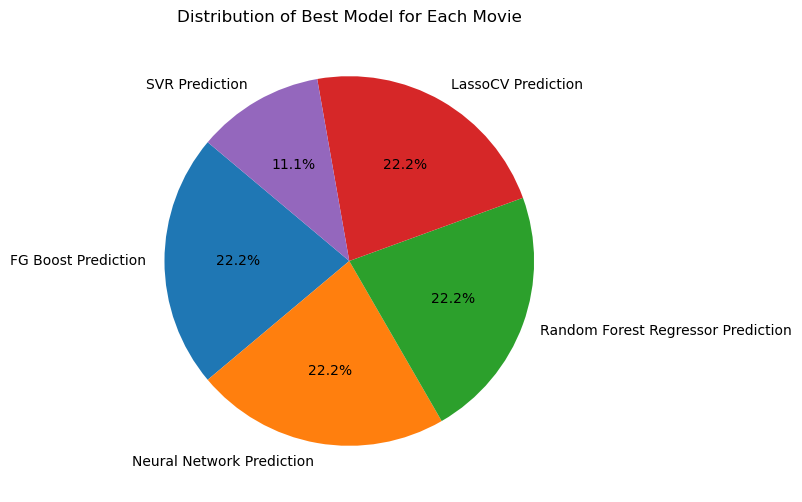

In [226]:
# Create a visualization pie chart of the distribution of which model performed best each time by using the 'Best Model' column
best_model_counts = test_df['Best Model'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(best_model_counts, labels=best_model_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Best Model for Each Movie")
plt.show()

In [227]:
performance_metrics = pd.DataFrame(columns = ["Metric", "LassoCV Prediction", "Random Forest Regressor Prediction","Neural Network Prediction","SVR Prediction","FG Boost Prediction","Dummy Prediction"])
performance_metrics["Metric"] = ["Mean Error (ME)", "Mean Absolute Deviation (MAD)", "Mean Absolute Percentage Error (MAPE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)"]
# Calculate Performance metrics for the new movies for each model
for model in ["LassoCV Prediction", "Random Forest Regressor Prediction", "Neural Network Prediction","SVR Prediction", "FG Boost Prediction", "Dummy Prediction"]:
    ME = (test_df["My Rating"] - test_df[model]).mean()
    MAD = mean_absolute_error(test_df["My Rating"], test_df[model])
    MAPE = mean_absolute_percentage_error(test_df["My Rating"], test_df[model])
    MSE = mean_squared_error(test_df["My Rating"], test_df[model])
    RMSE = np.sqrt(MSE)
    # Add results to a new table
    performance_metrics[model] = [ME, MAD, MAPE, MSE, RMSE]

performance_metrics

,Metric,LassoCV Prediction,Random Forest Regressor Prediction,Neural Network Prediction,SVR Prediction,FG Boost Prediction,Dummy Prediction
0,Mean Error (ME),-0.103333,-0.238889,-0.488889,0.083333,-0.383333,0.182222
1,Mean Absolute Deviation (MAD),0.430000,0.650000,0.540000,0.423333,0.716667,1.106667
2,Mean Absolute Percentage Error (MAPE),0.055201,0.089729,0.071007,0.053073,0.102654,0.140534
3,Mean Squared Error (MSE),0.274989,0.691500,0.479444,0.213411,1.023456,1.539378
4,Root Mean Squared Error (RMSE),0.524394,0.831565,0.692419,0.461964,1.011660,1.240717
